<a href="https://colab.research.google.com/github/bahadirbasaran/pulsarDetection/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment**

In [0]:
import pydot
import numpy as np
import pandas as pd
import seaborn as sb
from graphviz import Source
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.utils import resample
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import FitFailedWarning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error, confusion_matrix
simplefilter("ignore", UserWarning)
simplefilter("ignore", FutureWarning)
simplefilter("ignore", FitFailedWarning)
%matplotlib inline


# **Function Definitions**

In [0]:
def printDataframe(dataframe, frame_style, sort_by, ascending=False):
  dataframe = dataframe.sort_values(by=sort_by, ascending=ascending)
  display(dataframe.style.set_table_styles(frame_style).hide_index())

def hover(hover_color="#e6e6ff"):
  return dict(selector="tr:hover", props=[("background-color", "%s" % hover_color), ("font-weight", "bold")])

def plot_confusion_matrix(classifier, y_true, y_pred):
  #plt.figure(figsize=(10,5))
  cf_matrix = confusion_matrix(y_true, y_pred)
  group_names = ['True Neg.', 'False Pos.', 'False Neg.', 'True Pos.']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names, group_counts)]
  labels = np.asarray(labels).reshape(2,2)
  sb.heatmap(cf_matrix, annot=labels, fmt = "", linecolor="k", linewidths=3)
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.title("{} Confusion Matrix".format(classifier), fontsize=16)
  #plt.show()

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
  #plt.figure(figsize=(10,5))
  plt.title(title, fontsize=16)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel("Training Examples")
  
  if scoring == None:
    plt.ylabel("Score")
  else:
    plt.ylabel(scoring + " Score")

  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
  plt.legend(loc="best")
  #plt.show()

def plot_feature_importances(classifier, data):
  plt.figure(figsize=(10,5))
  featureImportances = pd.Series(classifier.feature_importances_, index=data.columns[:-1]).sort_values(ascending=False)
  sb.barplot(x=featureImportances, y=featureImportances.index)
  plt.title('Feature Importances', fontsize=16)
  plt.xlabel('Score')
  plt.show()

def plot_decision_tree(classifier, featureNames, rotate=False):
  dot_data = export_graphviz(classifier, out_file=None, rotate=rotate, feature_names=featureNames, filled=True, rounded=True,special_characters=True)
  pdot = pydot.graph_from_dot_data(dot_data)
  # Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
  pdot[0].set_graph_defaults(size = "\"22,12\"")
  graph = Source(pdot[0].to_string())
  display(graph)

def evaluateClassifier(classifier, y_true, y_pred, df_stats):
  # Calculate evaluation metrics  
  score_precision = precision_score(y_true, y_pred)
  score_recall    = recall_score(y_true, y_pred)
  score_f1        = f1_score(y_true, y_pred)
  score_acc       = accuracy_score(y_true,y_pred)
  score_mse       = mean_squared_error(y_true, y_pred)

  # Print current model's statistics out
  dataframe_model = pd.DataFrame(columns=['Model on Test Data', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'MSE'])
  dataframe_model = dataframe_model.append({"Model on Test Data": classifier, "Accuracy": "%.4f" % score_acc, "F1 Score": "%.4f" % score_f1, 
                                            'Precision': "%.4f" % score_precision, 'Recall': "%.4f" % score_recall, "MSE": "%.4f" % score_mse}, ignore_index=True)
  print("\n")
  printDataframe(dataframe=dataframe_model, frame_style=frameStyle, sort_by='Accuracy')
  print("\n")

  plot_confusion_matrix(classifier, y_true, y_pred)

  # Append current model's statistics into global dataframe
  if classifier not in df_stats.values:
    df_stats = df_stats.append({"Model": classifier, "Accuracy": "%.4f" % score_acc, "F1 Score": "%.4f" % score_f1, 
                                'Precision': "%.4f" % score_precision, 'Recall': "%.4f" % score_recall, "MSE": "%.4f" % score_mse}, ignore_index=True)
  return df_stats

def createDataSplits(dataset, list_dataColumns, targetColumn, testSizeRatio, randomState=42, obj_preprocessing=None, printStats=False):   
  # to selectively create the splits
  X = dataset[dataset.columns[list_dataColumns]]
  y = dataset[dataset.columns[targetColumn]]
    
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSizeRatio, random_state=randomState, stratify=y)
    
  if obj_preprocessing is not None:
    X_train = obj_preprocessing.fit_transform(X_train)
    X_test = obj_preprocessing.transform(X_test)
    # Index of X_train and X_test are changed. We must reset the index of y_train and y_test.Otherwise, index mismatch error.
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

  if printStats == True:
    print("\nX_train Size: {}  ||  y_train Size: {}\nX_test  Size:  {}  ||  y_test  Size:  {}".format(len(X_train), len(y_train), len(X_test), len(y_test)))

  return X_train, X_test, y_train, y_test

def mergeDataSplits(X_train, y_train, X_test, y_test):
  trainset = pd.concat([X_train, y_train], axis=1)
  testset = pd.concat([X_test, y_test], axis=1)
  mergedDataSet =  pd.concat([trainset, testset], axis=0)

  return mergedDataSet

# **Data Import**

In [0]:
dataset = pd.read_csv('https://raw.githubusercontent.com/bahadirbasaran/pulsarDetection/master/pulsar_stars.csv')
dataset.info()
print("\n")
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB




,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


# **Data Visualization**



Correlation Matrix Heatmap




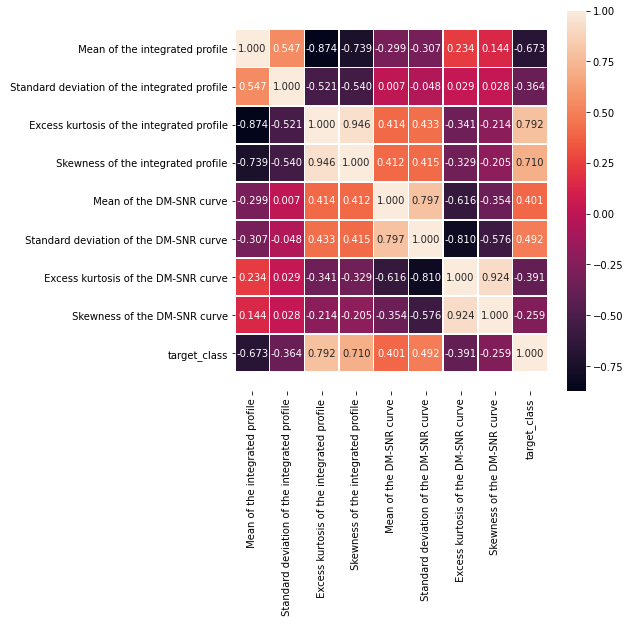



Distribution Plot




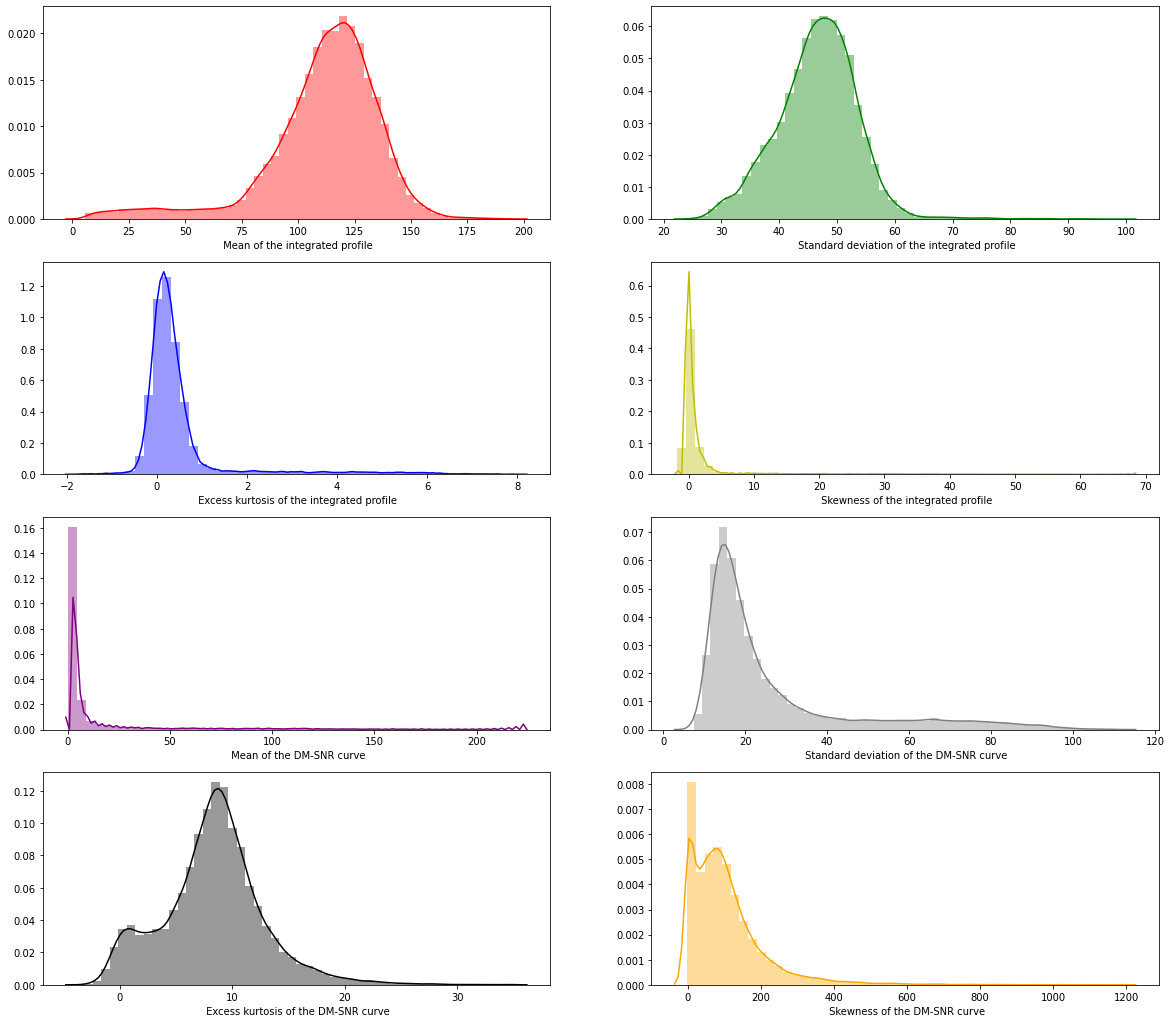



Pair Plot




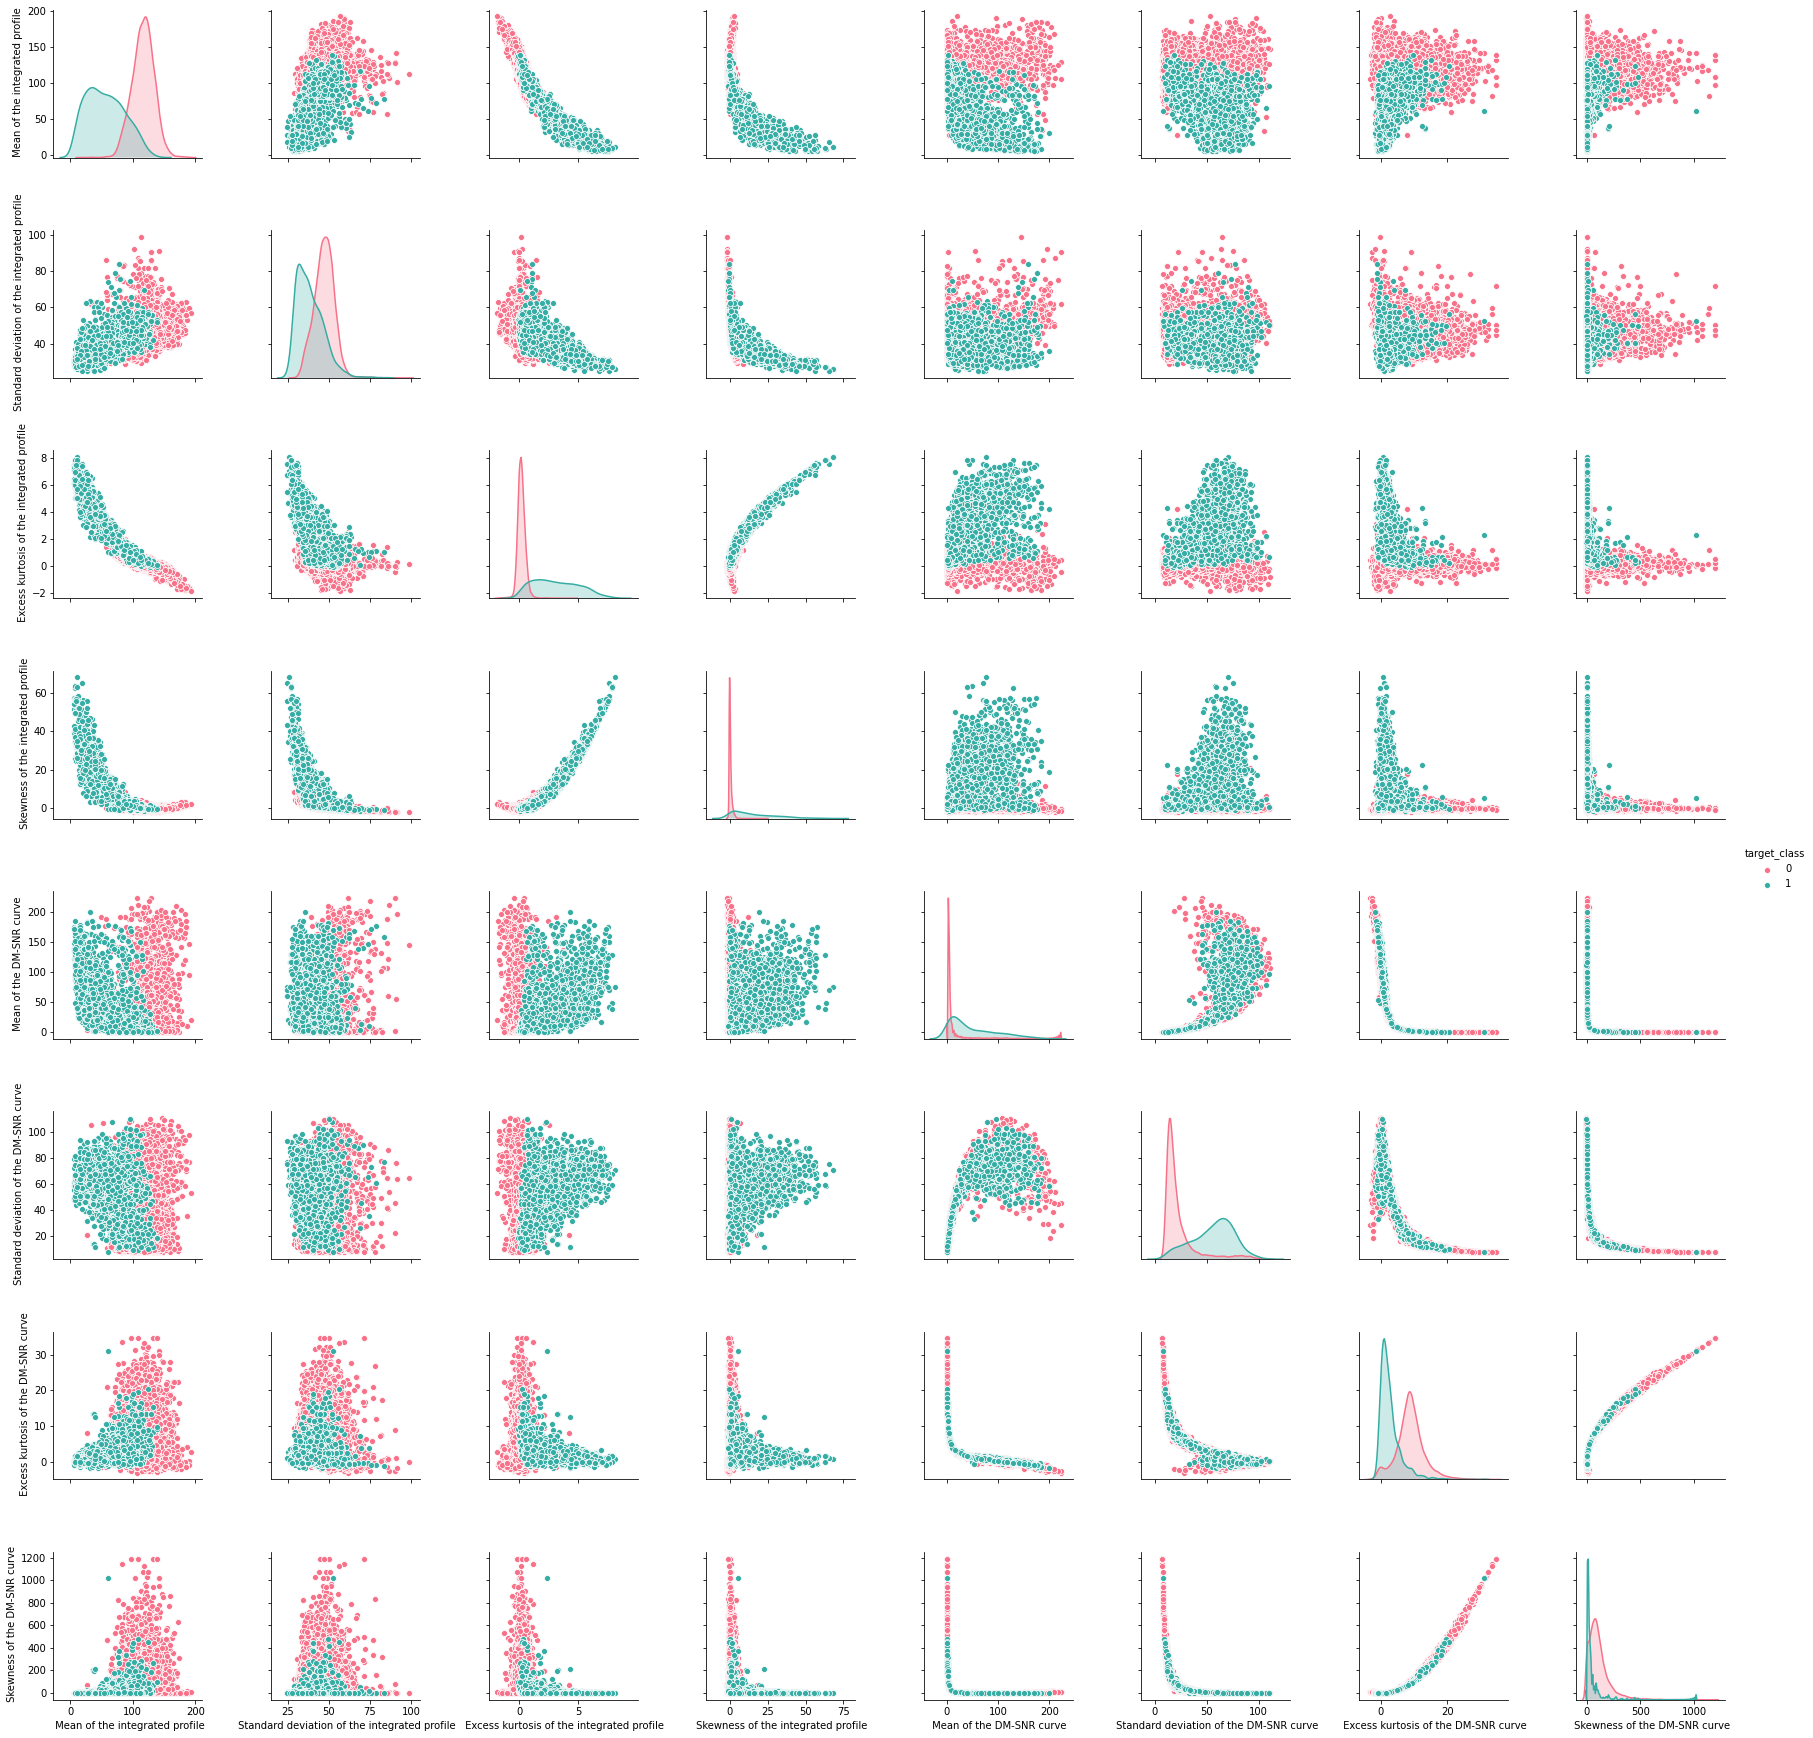



Box Plot




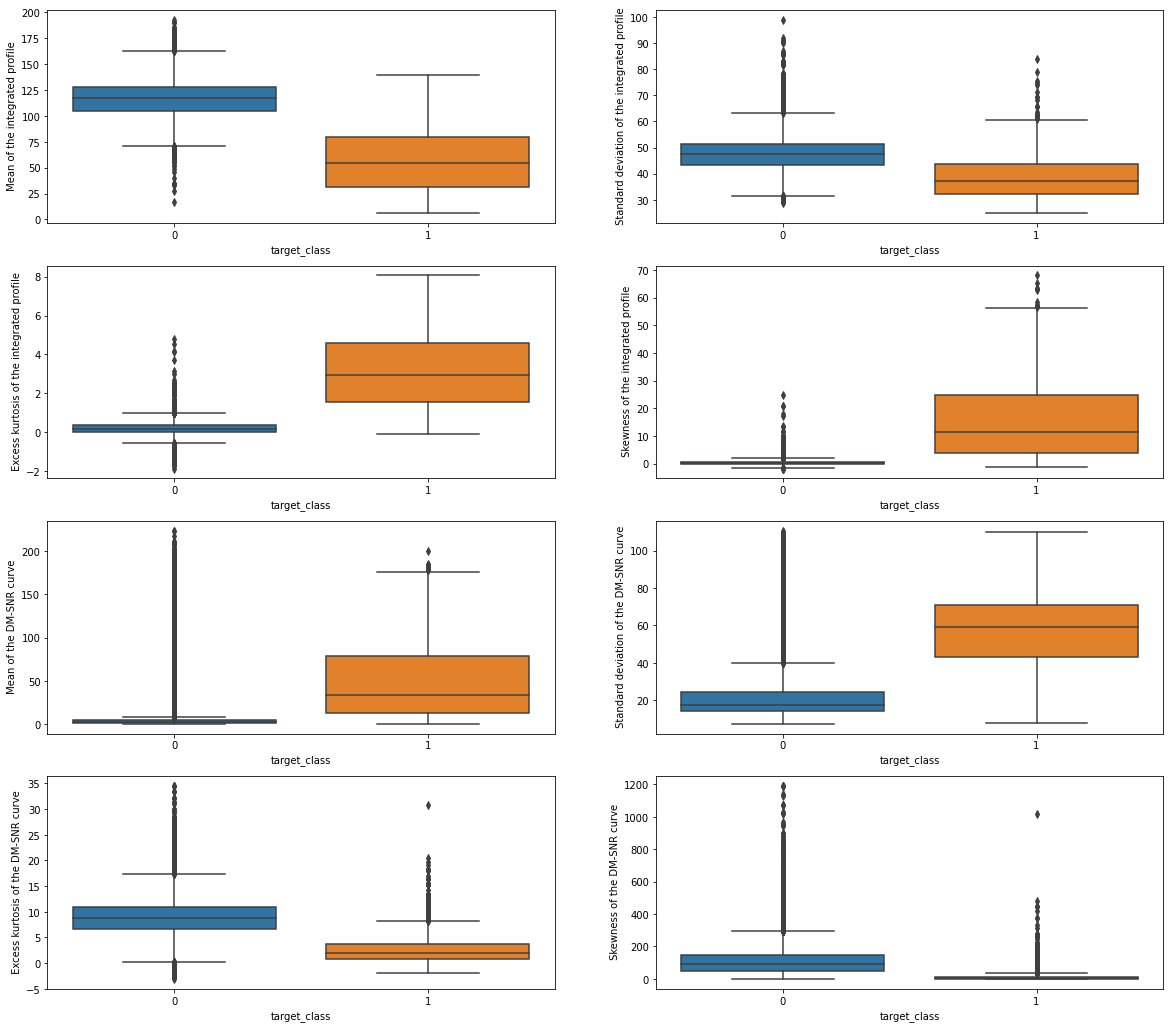

In [0]:
# Correlation Matrix Heatmap
print('\033[1m' + '\033[4m' + '\033[36m' + "\n\nCorrelation Matrix Heatmap\n\n")
_, ax = plt.subplots(figsize = (7,7))
hm = sb.heatmap(dataset.corr(), annot = True, linewidths=.5, fmt = ".3f", ax=ax)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Dist Plot
print('\033[1m' + '\033[4m' + '\033[36m' + "\n\nDistribution Plot\n\n")
plt.figure(figsize=(20,18))
for i, column, color in zip(list(range(0,8)), dataset.columns[:-1], ['r', 'g', 'b', 'y', 'purple', 'grey', 'black', 'orange']):
  plt.subplot(4,2,i+1)
  sb.distplot(dataset[column], color=color)        
plt.show()

# Pair Plot
print('\033[1m' + '\033[4m' + '\033[36m' + "\n\nPair Plot\n\n")
sb.pairplot(data=dataset, palette="husl", hue="target_class", vars=list(dataset.columns[:-1]), height=3)
plt.show()

# Box Plot
print('\033[1m' + '\033[4m' + '\033[36m' + "\n\nBox Plot\n\n")
plt.figure(figsize=(20,18))
for i in range(8):
  plt.subplot(4,2,i+1)
  sb.boxplot(data=dataset, y=dataset.columns[i], x="target_class")
plt.show()

# **Data Splits**

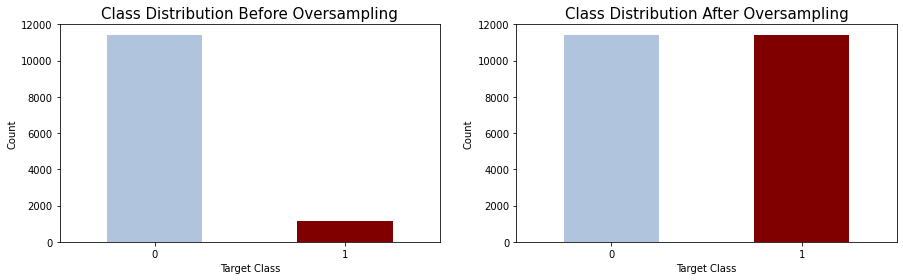


X_train Size: 22800  ||  y_train Size: 22800
X_test  Size:  5349  ||  y_test  Size:  5349


In [0]:
# Due to the imbalancy, we need to balance the dataset by oversampling.
# In order to prevent leakage, only the training set should be oversampled.
# If it is desired to do feature scaling, it is better to do it before oversampling.
# Therefore, "createDataSplits" is used twice. The former one to scale, the latter one to create final splits from the scaled&oversampled dataset.

# i.g: Let's assume we have 20 samples in dataset.
# We'd like to do oversampling and in the end, we'd like to have test set with size of 0.2*total.
# If we directly split with the 0.2 ratio before oversampling -> size_train = 16, size_test = 4. 
# Let's assume that in the trainset -> classA: 14 samples, classB: 2 samples.
# After oversampling: trainset -> classA: 14 samples, classB: 14 samples. -> size_train = 28, size_test = 4
# We desired to have test set with the ratio 0.2 , however, we have 4/(28+4) = 0.125

# Desired splitting ratio for the final splits.
ratio_testSet = 0.19        

# To find the value that should be passed as parameter to the "createDataSplits":
size_majorityClass = len(dataset[dataset.target_class==0])
size_testSet = 2 * ratio_testSet * size_majorityClass * len(dataset) / (len(dataset) - ratio_testSet * len(dataset) + 2 * ratio_testSet * size_majorityClass)
tmp_ratio_testSet = size_testSet / len(dataset)

# Create the initial data splits by feature scaling through MinMaxScaler.
X_train, X_test, y_train, y_test = createDataSplits(dataset, [0,1,2,3,4,5,6,7], 8, tmp_ratio_testSet, obj_preprocessing= MinMaxScaler())

# Reshape the X_train
X_train = pd.DataFrame(X_train)
X_train.columns = dataset.columns[:-1]

# Merge y_train with the scaled X_train and split the samples into minority and majority frames.
X = pd.concat([X_train, y_train], axis=1)
df_minority = X[X.target_class==1]
df_majority = X[X.target_class==0]

# Visualize the imbalancy of the training set
fig, ax = plt.subplots(1,2, figsize = (15,4))
plt.subplot(1,2,1)
X['target_class'].value_counts().plot(kind='bar', rot=0, color=['lightsteelblue', 'maroon'], yticks=list(range(0, 12001, 2000)))
plt.xlabel("Target Class")
plt.ylabel("Count")
plt.title("Class Distribution Before Oversampling", fontsize=15)

# Oversample the minority class to match the size of majority class and merge them
df_minority_oversampled = resample(df_minority, n_samples=len(df_majority), random_state=42)   
train_oversampled = pd.concat([df_majority, df_minority_oversampled])

# Visualize the balanced training set
plt.subplot(1,2,2)
train_oversampled['target_class'].value_counts(ascending=True).plot(kind='bar', rot=0, color=['lightsteelblue', 'maroon'], yticks=list(range(0, 12001, 2000)))
plt.xlabel("Target Class")
plt.ylabel("Count")
plt.title("Class Distribution After Oversampling", fontsize=15)
plt.show()

# Extract the X_train and y_train from the oversampled training set
X_train = train_oversampled.drop('target_class', axis=1)
y_train = train_oversampled.target_class

# Reshape the X_train and X_test
X_train = pd.DataFrame(X_train)
X_train.columns = dataset.columns[:-1]
X_test= pd.DataFrame(X_test)
X_test.columns = dataset.columns[:-1]

# Merge the data splits to create the new -scaled and oversampled- dataset
dataset_oversampled = mergeDataSplits(X_train, y_train, X_test, y_test)

# Create the new data splits from the new dataset
X_train, X_test, y_train, y_test = createDataSplits(dataset_oversampled, [0,1,2,3,4,5,6,7], 8, ratio_testSet, obj_preprocessing=None, printStats=True)


# **Model Preparation&Evaluation**

**Model Preparation**

In [0]:
# Hyperparameter Sets to be used in Grid Search
params_LR  = {'C': [0.01, 0.1, 1, 10, 100]}
params_SVC = {'C': [10, 100], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'poly']}
params_DT  = {"criterion": ["gini", "entropy"], "max_depth": [13, 14, 15]} 
params_RF  = {"criterion": ["gini", "entropy"], "max_depth": [13, 14, 15], "n_estimators": [5, 100]}

list_paramSets = [params_LR, params_SVC, params_DT, params_RF]
list_classifiers = [LogisticRegression(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
list_clfNames = ["Logistic Regression", "Support Vector Machines", "Decision Tree", "Random Forest"]

# Dataframe for model and corresponding metric scores
dataframe_stats = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'MSE'])

# Dataframe for parameter set and corresponding mean cross validation score pairs
dataframe_grid  = pd.DataFrame(columns=['Hyperparameter Set', "Mean Cross-validation Score"])

# Dataframe stylers
frameStyle = [hover(), dict(selector="th", props=[("font-size", "120%"), ("text-align", "left"), ('min-width', '200px')])]
frameStyle2 = [hover(), dict(selector="th", props=[("font-size", "120%"), ("text-align", "left"), ('min-width', '500px')])]

# Number of splits to be used through cross validation
n_folds = 10

**Model Evaluation**

Logistic Regression

Mean Cross-validation Score of the Best Estimator: 0.9478



Hyperparameter Set,Mean Cross-validation Score
{'C': 100},0.9478
{'C': 10},0.9473
{'C': 1},0.9407
{'C': 0.1},0.9272
{'C': 0.01},0.9066



Logistic Regression Hyperparameter Set of the Best Estimator:

	Hyperparameter C: 100




Model on Test Data,Accuracy,F1 Score,Precision,Recall,MSE
Logistic Regression,0.9503,0.9387,0.9793,0.9013,0.0497


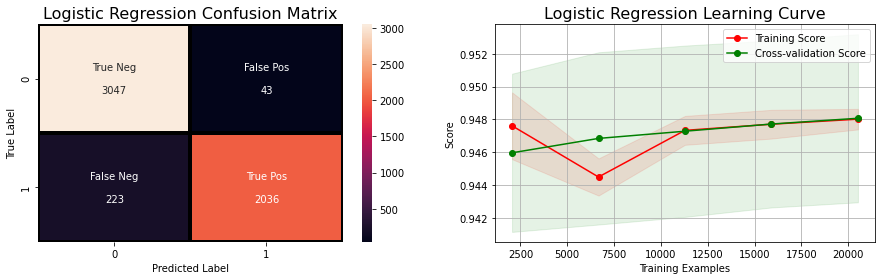


################################################################################################
################################################################################################

Support Vector Machines

Mean Cross-validation Score of the Best Estimator: 0.9534



Hyperparameter Set,Mean Cross-validation Score
"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.9534
"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",0.9531
"{'C': 100, 'gamma': 'scale', 'kernel': 'poly'}",0.9531
"{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}",0.9528
"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",0.9509
"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.9476
"{'C': 100, 'gamma': 'auto', 'kernel': 'poly'}",0.9401
"{'C': 10, 'gamma': 'auto', 'kernel': 'poly'}",0.9233



Support Vector Machines Hyperparameter Set of the Best Estimator:

	Hyperparameter C: 10
	Hyperparameter gamma: scale
	Hyperparameter kernel: rbf




Model on Test Data,Accuracy,F1 Score,Precision,Recall,MSE
Support Vector Machines,0.9570,0.9472,0.9833,0.9137,0.0430


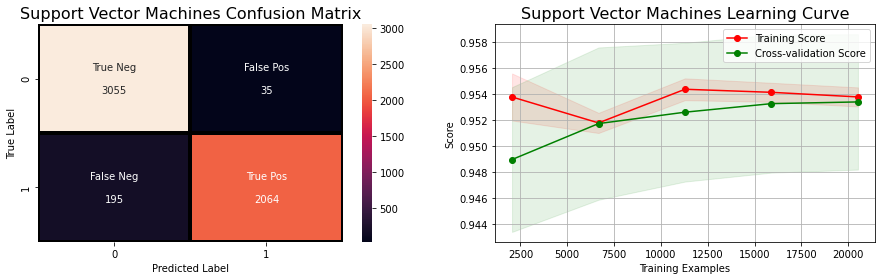


################################################################################################
################################################################################################

Decision Tree

Mean Cross-validation Score of the Best Estimator: 0.9811



Hyperparameter Set,Mean Cross-validation Score
"{'criterion': 'entropy', 'max_depth': 15}",0.9811
"{'criterion': 'gini', 'max_depth': 15}",0.9804
"{'criterion': 'entropy', 'max_depth': 14}",0.9787
"{'criterion': 'gini', 'max_depth': 14}",0.9782
"{'criterion': 'gini', 'max_depth': 13}",0.9762
"{'criterion': 'entropy', 'max_depth': 13}",0.9761



Decision Tree Hyperparameter Set of the Best Estimator:

	Hyperparameter criterion: entropy
	Hyperparameter max_depth: 15




Model on Test Data,Accuracy,F1 Score,Precision,Recall,MSE
Decision Tree,0.9813,0.9782,0.9643,0.9925,0.0187


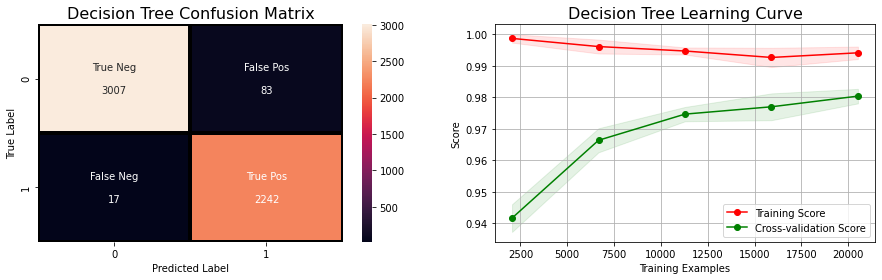

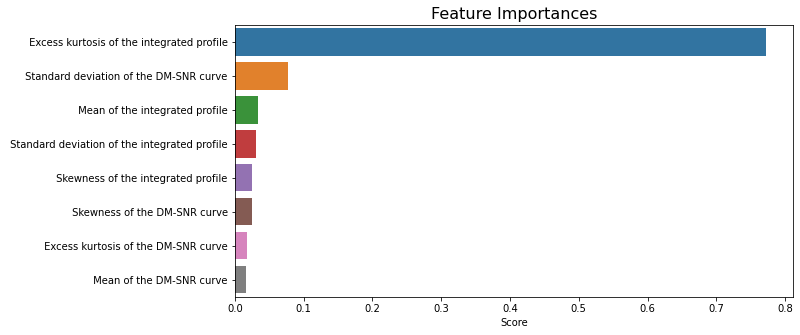

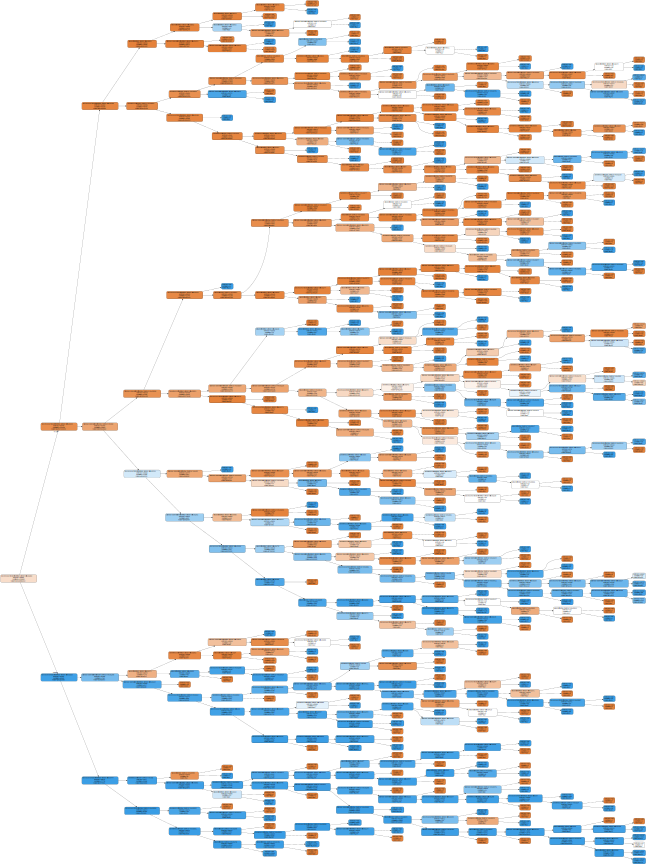


################################################################################################
################################################################################################

Random Forest

Mean Cross-validation Score of the Best Estimator: 0.9918



Hyperparameter Set,Mean Cross-validation Score
"{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 100}",0.9918
"{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 100}",0.9914
"{'criterion': 'gini', 'max_depth': 14, 'n_estimators': 100}",0.9908
"{'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 100}",0.9900
"{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 100}",0.9894
"{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 5}",0.9888
"{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 5}",0.9887
"{'criterion': 'gini', 'max_depth': 14, 'n_estimators': 5}",0.9881
"{'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 100}",0.9880
"{'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 5}",0.9859



Random Forest Hyperparameter Set of the Best Estimator:

	Hyperparameter criterion: gini
	Hyperparameter max_depth: 15
	Hyperparameter n_estimators: 100




Model on Test Data,Accuracy,F1 Score,Precision,Recall,MSE
Random Forest,0.9936,0.9925,0.9894,0.9956,0.0064


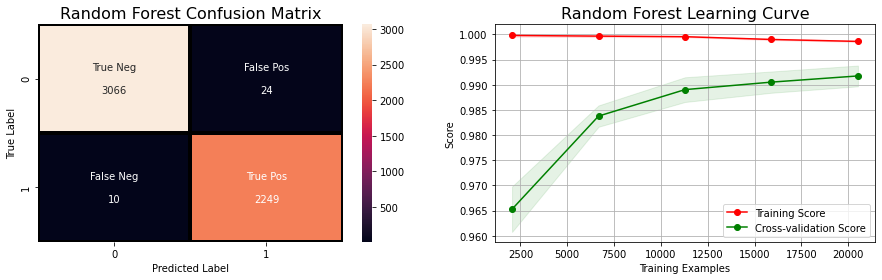

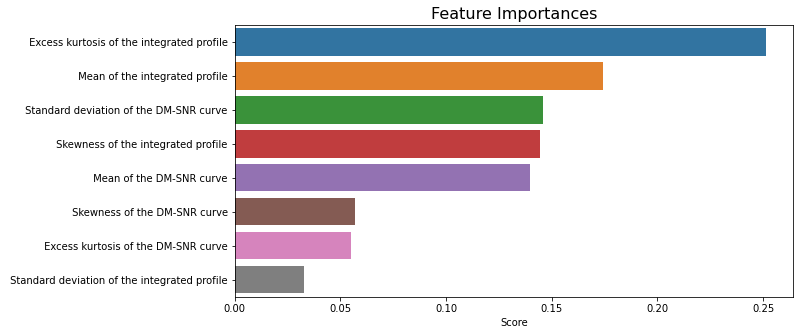


################################################################################################
################################################################################################



Model,Accuracy,F1 Score,Precision,Recall,MSE
Random Forest,0.9936,0.9925,0.9894,0.9956,0.0064
Decision Tree,0.9856,0.9831,0.9731,0.9934,0.0144
Support Vector Machines,0.9570,0.9472,0.9833,0.9137,0.0430
Logistic Regression,0.9503,0.9387,0.9793,0.9013,0.0497


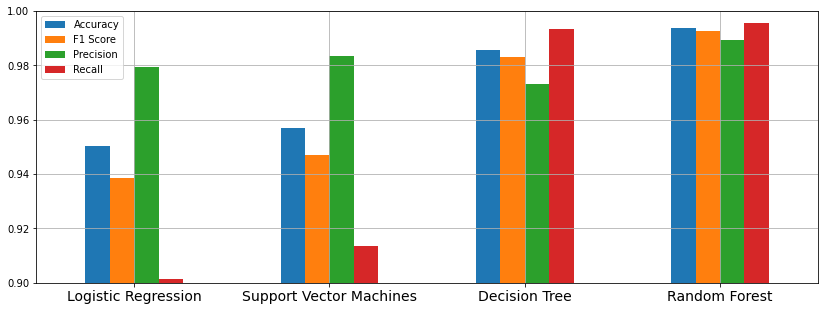

In [0]:
# Iteratively select classifier, corresponding parameter set and name 
for classifier, paramSet, classifierName in zip(list_classifiers, list_paramSets, list_clfNames):
  
  gs = GridSearchCV(
                    estimator = classifier,
                    param_grid = paramSet,
                    cv = n_folds,
                    return_train_score=True,
                    n_jobs=-1               
                   )  
  gs.fit(X_train, y_train)

  print('\033[1m' + '\033[4m' + '\033[36m'  + classifierName + '\033[0m')
  print("\nMean Cross-validation Score of the Best Estimator: {}\n".format("%.4f" % gs.best_score_))

  # Print out each evaluated parameter set and corresponding mean cross validation score
  dataframe_grid = dataframe_grid.iloc[0:0]
  for param, i in zip(gs.cv_results_['params'], range(0, len(gs.cv_results_['params']))):
    dataframe_grid = dataframe_grid.append({"Hyperparameter Set": param, "Mean Cross-validation Score": "%.4f" % gs.cv_results_['mean_test_score'][i]}, ignore_index=True)
  printDataframe(dataframe=dataframe_grid, frame_style=frameStyle2, sort_by="Mean Cross-validation Score")

  print("\n{} Hyperparameter Set of the Best Estimator:\n".format(classifierName))
  for param in paramSet.keys():
    print("\tHyperparameter {}: {}".format(param, gs.best_estimator_.get_params()[param]))
  
  y_pred = gs.best_estimator_.predict(X_test)

  fig, ax = plt.subplots(1,2, figsize = (15,4))
  
  plt.subplot(1,2,1)
  dataframe_stats = evaluateClassifier(classifierName, y_test, y_pred, dataframe_stats)

  cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  title = classifierName + " Learning Curve"
  plt.subplot(1,2,2)
  plot_learning_curve(gs.best_estimator_, title, X_train, y_train, cv=cv, n_jobs=-1)
  plt.show()

  if classifierName in ["Decision Tree", "Random Forest"]:
    plot_feature_importances(gs.best_estimator_, dataset)
    if classifierName == "Decision Tree":
      plot_decision_tree(gs.best_estimator_, dataset.columns[:-1], rotate=True)

  print('\033[1m' + '\033[94m' + "\n################################################################################################")
  print("################################################################################################\n" + '\033[0m')

# List the results
printDataframe(dataframe=dataframe_stats, frame_style=frameStyle, sort_by=['Accuracy', 'F1 Score'])
print("\n")

# Compare the results with bar graph
getDataFrameValues = lambda e: [float(dataframe_stats[e].values[0]), float(dataframe_stats[e].values[1]), float(dataframe_stats[e].values[2]), float(dataframe_stats[e].values[3])]

df_comp = pd.DataFrame({'Accuracy':   getDataFrameValues('Accuracy'),
                        'F1 Score':   getDataFrameValues('F1 Score'),
                        'Precision':  getDataFrameValues('Precision'),
                        'Recall':     getDataFrameValues('Recall')}, 
                        index=        dataframe_stats['Model'].values)

df_comp.plot.bar(figsize=(14,5), grid=True).set_ylim(0.90,1.00)
plt.xticks(rotation=0, fontsize=14)
plt.show()